In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join('..')))

from models import gptv1

config = gptv1.GPTv1Config(device="mps", batch_size=16, block_size=256, n_heads=6)
device = config.device

In [2]:
filepath = "../../data/freud/interpretation-of-dreams.txt"
input_file = open(filepath, 'r', encoding='utf-8')
raw_text = input_file.read()
input_file.close()

In [3]:
from utilities import text_cleaning
from utilities import tokenizer2 as tokenizer
text = text_cleaning.basic_cleaning(raw_text)
td = tokenizer.create_tokenizer(text, num_tokens=256 + 16)
# td = tokenizer.reduce_token_dictionary(td, text)
print(td)
print(len(td.token_set))

TokenDictionary(token_set=['\n', ' ', '!', '&', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '·', 'À', 'Â', 'Æ', 'É', 'Ü', 'à', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ó', 'ô', 'û', 'ü', 'Œ', 'œ', '̓', 'Ψ', 'έ', 'ν', 'ς', 'υ', 'χ', '–', '—', '‘', '’', '“', '”', ' t', 'he', ' a', 're', ' the', 'in', ' o', 'on', ' w', ' s', 'at', 'is', 'en', ' of', ' d', 'er', ' c', 'it', ' in', ' f', ' m', ' b', ' p', 'ion', 'ed', ' th', 'es', ' to', 'or', ' h', 'am', 'ic', ' an', 'ou', 'ing', 'an', 'al', 'ream', ' dream', 'le', 'ar', 'ent', ' wh', ' re', 'om', 'as', ' e', ' and', ' n', 'ly', ' be', 'ct', ' I', ' is', 'ot', 'st', 'ation', 'ich', ' that', 'ce', ' which', ' con', 've',

In [4]:
characters, idx_to_token, token_to_idx = td
encode = tokenizer.get_encoder(td)
decode = tokenizer.get_decoder(td)
data = torch.tensor(encode(text), dtype=torch.long).to(device=device)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

block_size, batch_size = config.block_size, config.batch_size
def get_batch(split):
  data = train_data if split == 'train' else val_data
  idxs = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in idxs])
  y = torch.stack([data[i+1:i+block_size+1] for i in idxs])
  return x, y

@torch.no_grad()
def estimate_val_loss(model):
  model.eval()
  X, Y = get_batch("val")
  X = X.to(device=device)
  Y = Y.to(device=device)
  _, loss = model(X, Y)
  model.train()
  return loss.item()


In [5]:
from collections import Counter
def getcounts(tensor):
  tokens, counts = tensor.flatten().unique(return_counts=True)
  return Counter(dict(zip(tokens.tolist(), counts.tolist())))

print(getcounts(train_data))
print(getcounts(val_data))


Counter({71: 24416, 56: 17005, 65: 16761, 70: 12641, 69: 9541, 55: 8783, 64: 8220, 66: 7416, 59: 6560, 57: 6176, 74: 5483, 63: 5202, 67: 5060, 119: 4608, 52: 4583, 54: 4478, 76: 4047, 117: 4023, 116: 3935, 113: 3813, 53: 3612, 1: 3479, 127: 3467, 147: 3367, 72: 3254, 115: 3053, 58: 2850, 123: 2546, 6: 2337, 167: 2176, 125: 2137, 175: 1992, 136: 1949, 124: 1931, 138: 1918, 8: 1896, 114: 1775, 151: 1751, 140: 1704, 152: 1671, 157: 1652, 190: 1582, 31: 1533, 60: 1519, 148: 1515, 129: 1507, 146: 1407, 184: 1382, 130: 1365, 122: 1358, 139: 1323, 174: 1323, 62: 1307, 153: 1303, 163: 1181, 169: 1172, 145: 1138, 142: 1127, 159: 1109, 135: 1091, 156: 1028, 178: 999, 171: 990, 166: 911, 42: 892, 164: 841, 161: 837, 224: 830, 176: 821, 121: 816, 149: 814, 134: 809, 216: 779, 205: 773, 162: 760, 231: 748, 211: 747, 132: 741, 196: 734, 186: 699, 189: 699, 241: 689, 73: 680, 128: 678, 155: 675, 259: 661, 143: 659, 51: 651, 168: 647, 172: 642, 177: 610, 179: 604, 222: 596, 131: 594, 244: 582, 118: 57

In [7]:
m = gptv1.LanguageModel(len(characters), config).to(device)
m.compile()

optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
  optimizer,
  mode='min',
  factor=0.1,
  patience=5
)

import time
from torch.amp import autocast
from tqdm import tqdm
from utilities import plotting2 as plotting
p = plotting.LossPlotter()

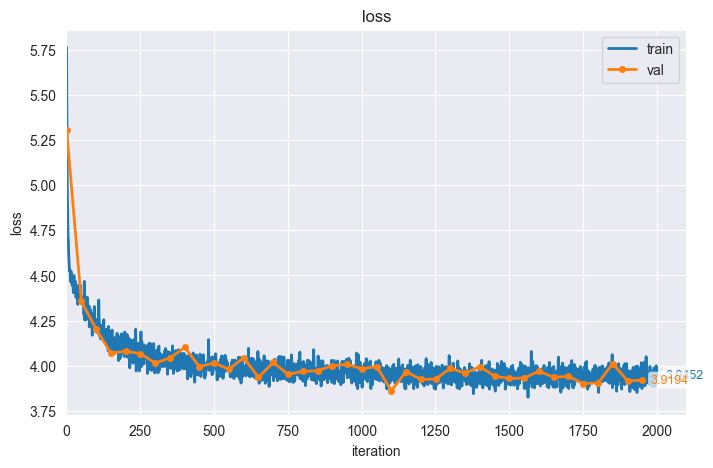

In [8]:
for steps in range(2000):
	xb, yb = get_batch('train')
	xb = xb.to(device)
	yb = yb.to(device)
	with autocast(device_type="mps", dtype=torch.float16):
		logits, loss = m(xb, yb)
	optimizer.zero_grad(set_to_none=True)
	loss.backward()
	optimizer.step()
	train_loss, val_loss = loss.item(), None
	if steps % 50 == 0:
		val_loss = estimate_val_loss(m)
		scheduler.step(val_loss)
	p.update(train_loss, val_loss)
	torch.mps.synchronize()

In [9]:
idx = torch.tensor([encode("The mind ")], dtype=torch.long, device=device)
print(idx)
print("The mind ", end="", flush=True)
for token in m.generate(idx, max_new_tokens=200):
	print(decode([token.item()])[0], end="", flush=True)
print()

tensor([[42, 56, 64, 65,  1]], device='mps:0')
The mind n fromici inch myugnerwsehbtsitomheotrenttmstlg ofsz and b he dtmtdrmpel.Failseatione”reaingvurgifanhnornich have dreamh cltonf,antwksin aninglfern inatense:“otnretoreediln destmn gfeb tett

KeyboardInterrupt: 

In [ ]:
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

6.214726 M parameters


In [ ]:
torch.save(m.state_dict(), "gptv1_sample1.pt")

Nice — thanks for the concrete numbers. A training loss of **3.2** vs validation **5.7** is a large gap and tells a clear story: either **overfitting** or **train/validation distribution mismatch** (or both). Below I’ll explain the likely causes, give concrete diagnostics you can run *right now*, and list prioritized, actionable fixes you can try.

---

## Quick reality check (what these numbers mean)

* Per-token perplexities:
  train PPL = `exp(3.2) ≈ 24.5`
  val PPL   = `exp(5.7) ≈ 298`
* Big gap — model fits training tokens much better than validation tokens.

**Important:** because you switched from a char model to a subword model, raw token losses are not directly comparable to previous char losses. You should normalize for token size when comparing (see below).

---

## Immediate diagnostics (run these now)

1. **Tokenizer consistency**
   Confirm the *same tokenizer/version/model* is used for training and validation tokenization. If train and val were tokenized differently, large gaps appear instantly.

2. **Check for `<unk>` / OOV rate**
   Compute fraction of tokens in validation that are unknown or mapped to an `<unk>` token. High OOV on val → huge loss.

3. **Distribution mismatch**
   Compare token frequency histograms between train and val (top-1k tokens, tail mass). Large differences = mismatch.

4. **Average chars-per-token**
   Compute `avg_chars_per_token = total_chars / total_tokens` on both splits. You’ll need this for normalized comparisons.

5. **Per-token-length normalized loss**
   Convert token loss to loss-per-character:

   ```
   loss_per_char = loss_per_token / avg_chars_per_token
   ```

   and then `char_ppl = exp(loss_per_char)`. This lets you compare to your old char model.

6. **Overfit signs**
   Check validation loss curve vs training loss curve. If train keeps dropping and val plateaus/rises → overfitting.

7. **Batch/evaluation bug search**

   * Ensure eval uses same masking/prefix/seq-len and that you're not accidentally including padding in loss (or not masking it).
   * Ensure train uses teacher forcing same as eval.
   * Re-tokenize a handful of validation examples and verify the tokens make sense.

---

## Likely causes (with how they tie to your numbers)

1. **Huge vocabulary size → harder softmax**
   Subword vocab of tens of thousands makes random-init predictions much worse and increases early loss. This influences both train and val but train can overfit.

2. **Overfitting to subword idiosyncrasies**
   BPE tokens can be rarer and more specific; model memorizes token combinations in train but fails to generalize.

3. **Train/validation tokenization mismatch**
   If e.g. training had leading spaces preserved and validation didn’t (or different normalization), the model’s predictions will be wrong on val.

4. **High OOV / rare token mass in validation**
   If validation contains many tokens or token sequences that were rare in training, loss will spike.

5. **Regularization / capacity mismatch**
   Your model may be too big for training data amount (or lacks dropout/weight decay), so train gets low loss and val stays high.

6. **Optimization / learning rate issues**
   Wrong LR schedule (too high or too low, or no warmup) can cause poor generalization.

---

## Concrete, prioritized fixes (try in this order)

### Quick checks & fixes (cheap)

1. **Verify tokenizer parity** (most common cause).
2. **Report OOV%** — if >1–2% on val, shrink vocab or retrain tokenizer.
3. **Ensure padding tokens are masked out during loss** in evaluation.

### Strong, cheap experiments

4. **Compute normalized (per-character) losses** so you know if val is truly worse or just different units. (See formulas below.)
5. **Add / increase dropout** (e.g., 0.1 → 0.2 or 0.3) and/or **label smoothing** (0.05–0.1).
6. **Add weight decay** (e.g., 0.01) if not used.

### Medium-cost training changes

7. **Reduce vocabulary** (e.g., 50k → 32k or 20k) and retrain tokenizer, then retrain model (or fine-tune). Smaller vocab reduces sparsity and makes softmax easier.
8. **Use adaptive / sampled softmax** or **tied input/output embeddings** to stabilize training with large vocab.
9. **Use data augmentation**: token dropout, span masking, simple noise to inputs to reduce memorization.

### Stronger changes (if above fail)

10. **More data** or better data mixing: increase train set size, or mix in similar-domain data so validation distribution is covered.
11. **Regularization & early stopping** with validation checkpoints — stop before heavy overfitting.
12. **Different tokenization strategy**: consider byte-level BPE or Unigram LM (SentencePiece), or smaller merges — sometimes gives more robust tokens than your current BPE.

### Optimization schedule

13. **AdamW**, warmup (e.g., 1–2k steps), then cosine or linear decay. Typical LR starting point: `1e-4` for medium models; tune. Use gradient clipping (1.0).

---

## Useful formulas / examples

* token → char conversion:

  ```
  avg_chars_per_token = total_chars / total_tokens
  loss_per_char = loss_per_token / avg_chars_per_token
  char_ppl = exp(loss_per_char)
  ```

  Example: if `avg_chars_per_token = 4`:

  * train loss_per_char = `3.2 / 4 = 0.8` → `char_ppl = exp(0.8) ≈ 2.23`
  * val loss_per_char   = `5.7 / 4 = 1.425` → `char_ppl = exp(1.425) ≈ 4.16`

  So your model might still be competitive per character even if token loss looks large — but the big gap suggests a generalization problem beyond just unit scaling.

* perplexity: `PPL = exp(loss)` (token-level), or `exp(loss_per_char)` for char-level.

---

## Practical commands/snippets (pseudocode)

1. Tokenizer parity & OOV:

```python
# assuming tokenizer.encode returns list of token ids, unk id = tokenizer.unk_id
train_unk_rate = sum(id==unk for ids in train_tok for id in ids) / total_train_tokens
val_unk_rate   = sum(id==unk for ids in val_tok   for id in ids) / total_val_tokens
```

2. Avg chars per token:

```python
avg_chars_per_token_train = sum(len(s) for s in train_texts) / sum(len(tok) for tok in train_token_lists)
avg_chars_per_token_val   = ...
```

3. Per-token-frequency tail mass:

```python
from collections import Counter
c = Counter(t for ids in train_token_lists for t in ids)
# compare top-k frequencies to validation
```

---

## How to tell if it’s *only* a tokenization unit issue vs generalization

* If **loss_per_char** gap is small (train ≈ val after normalization) → mostly unit/granularity effect.
* If **loss_per_char** still shows big gap → real generalization / data mismatch / overfitting problem.

---

## Final short checklist you can run now

1. Confirm same tokenizer used for both splits.
2. Compute `val_unk_rate`.
3. Compute `avg_chars_per_token` and `loss_per_char` for train/val.
4. Plot token-frequency histograms for train vs val (top 5k tokens).
5. Try increasing dropout to 0.2 and add weight decay 0.01; retrain a few epochs and watch val.
6. If OOV high or distribution mismatch persists → reduce vocab (32k) or switch to byte-level.

---

If you want, I can:

* show a quick small script to compute `avg_chars_per_token`, `loss_per_char`, and OOV rate on your datasets (paste the tokenized counts or a small sample), **or**
* recommend specific hyperparameter values for your model size (tell me model size / vocab size / training steps), and I’ll give a tuned recipe.

Which of those would be most useful right now?